nodes.shape=(5, 10, 10, 2)
B_k=array([0, 0])


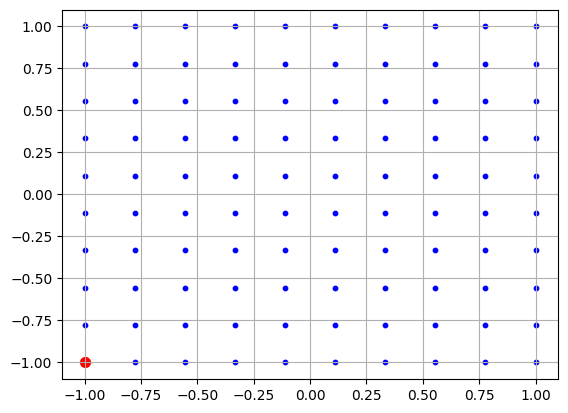

In [73]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = 5
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 10
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
nodes = nodes.reshape((1,) + nodes.shape)
nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

# Specify depots
## One depot node
depots_i = np.array([[0, 0]])
## Four depot nodes (one in each corner)
# depots_i = np.array([[0, 0], [0, n-1], [n-1, 0], [n-1,n-1]])

# Chose starting depot node
B_k = depots_i[0]
print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(nodes[0,:,:,0], nodes[0,:,:,1], c='blue', s=10)
plt.scatter(nodes[0,depots_i[:,0],depots_i[:,1],0], nodes[0,depots_i[:,0],depots_i[:,1], 1], c='red', s=50)
plt.grid()
plt.show()

In [74]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = (1. + q_k) * np.sqrt((nodes[0,i1,j1,0]-nodes[0,i2,j2,0]) ** 2 + (nodes[0,i1,j1,1]-nodes[0,i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
cost = cost.reshape((1,) + cost.shape)
cost = np.concatenate([cost for _ in range(k)], axis=0)
print(f"{cost.shape=}")


cost.shape=(5, 10, 10, 10, 10)


In [75]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# Set the OBJECTIVE FUNCTION
# ((1+q_k) * c_{ij}) * x^{k}_{ij}
x = m.addMVar((k,n,n,n,n), name='x', vtype=GRB.INTEGER, lb=0, ub=int(n*n-len(depots_i)), obj=cost)
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    is_depot_involved = False
    for depots_ii in depots_i:
        if (depots_ii[0] == i1 and depots_ii[1] == j1) or (depots_ii[0] == i2 and depots_ii[1] == j2):
            is_depot_involved = True
            # print((i1, j1, i2, j2))
            continue
    if is_depot_involved:
        continue
    _ = m.addConstr(x[:,i1,j1,i2,j2] <= 1)
# Above code handles A. Integer Constraints (4) and (5)


In [76]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
for i1, j1 in itertools.product(range(n), range(n)):
    is_depot_involved = False
    for depots_ii in depots_i:
        if depots_ii[0] == i1 and depots_ii[1] == j1:
            is_depot_involved = True
            continue
    if is_depot_involved:
        continue
    _ = m.addConstr(x[:,i1,j1,:,:].sum() == 1)
    _ = m.addConstr(x[:,:,:,i1,j1].sum() == 1)
# (8) and (9) Begin and end at same position B_k
_ = m.addConstrs(x[ki,B_k[0],B_k[1],:,:].sum() <= 1 for ki in range(k))
_ = m.addConstrs(x[ki,:,:,B_k[0],B_k[1]].sum() <= 1 for ki in range(k))
# (10) Every robot that visits a target leaves the target
_ = m.addConstrs(x[ki,:,:,i1,j1]-x[ki,i1,j1,:,:] == 0 for ki in range(k) for i1 in range(n) for j1 in range(n))

# Additional constraints: no loopholes!
_ = m.addConstrs(x[ki, i, j, i, j] == 0 for ki in range(k) for i in range(n) for j in range(n))
# Additional Constraints: symmetry!
_ = m.addConstrs(x[ki, i1, j1, i2, j2] == x[ki, i2, j2, i1, j1] for ki in range(k) for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))


In [77]:
# C. Degree Constraints (11), (12), (13), (14)
# This may be a lazy constraint because it is about sub tour elimination.
# Callback - use lazy constraints to eliminate sub-tours
from itertools import combinations

# TODO: complete implementing constraints for subtour elimination
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        for ki in range(k):
            selected = np.transpose(np.where(vals[ki] > 0.5))
            # find the shortest cycle in the selected edge list
            min_tour, _ = subtour(selected)
            if len(min_tour) < n * n / k: # THIS IS MOCK
                m.cbLazy(gp.quicksum(m._vars[ki, n1[0], n1[1], n2[0], n2[1]].item() for n1, n2 in combinations(min_tour, 2)) <= (len(min_tour)-1)/k)

# Given a list of edges, find the shortest subtour

def subtour(edges):
    unvisited = [(i, j) for i in range(n) for j in range(n)]
    cycle = range(n*n) # Dummy - guaranteed to be replaced
    all_cycles = []
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = []
            for i1, j1, i2, j2 in edges:
                if (i1, j1) == current and (i2, j2) in unvisited:
                    neighbors.append((i2, j2))
                elif (i2, j2) == current and (i1, j1) in unvisited:
                    neighbors.append((i1, j1))
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle # New shortest subtour
            all_cycles.append(cycle)
    return cycle, all_cycles

In [78]:
# Fuel Constraints (15), (16), (17), (18), (19), (20)
# This includes adding another decision variable

In [79]:
m._vars = x
m.Params.lazyConstraints = 1
m.optimize(subtourelim)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (armlinux64)

CPU model: ARM64
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license - for non-commercial use only - registered to luffs.ottoman04@icloud.com
Optimize a model with 149713 rows, 50000 columns and 347505 nonzeros
Model fingerprint: 0xb29d2a15
Variable types: 0 continuous, 50000 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 3e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e+00, 1e+00]
Presolve removed 149609 rows and 25250 columns
Presolve time: 0.08s
Presolved: 104 rows, 24750 columns, 49500 nonzeros
Variable types: 0 continuous, 24750 integer (24750 binary)
Root relaxation: objective 2.430125e+01, 156 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd

In [80]:
# selected = np.transpose(np.where(m._vars.x > 0.5))
# pp(m._vars.x)
shortest_tours = []
selected = m._vars.x
for ki in range(k):
    shortest_tour, all_tours = subtour(np.transpose(np.where(m._vars.x[ki] > 0.5)))
    shortest_tour.append(shortest_tour[0])
    shortest_tours.append(shortest_tour)
    print(f"robot #{ki}")
    print(f"Shortest Tour: {shortest_tour}")
    # for i, t in enumerate(all_tours):
    #     print(f"Tour #{i}: {all_tours}")
    print("-" * 50)


robot #0
Shortest Tour: [(9, 9), (9, 9)]
--------------------------------------------------
robot #1
Shortest Tour: [(9, 9), (9, 9)]
--------------------------------------------------
robot #2
Shortest Tour: [(9, 9), (9, 9)]
--------------------------------------------------
robot #3
Shortest Tour: [(9, 9), (9, 9)]
--------------------------------------------------
robot #4
Shortest Tour: [(9, 7), (9, 7)]
--------------------------------------------------


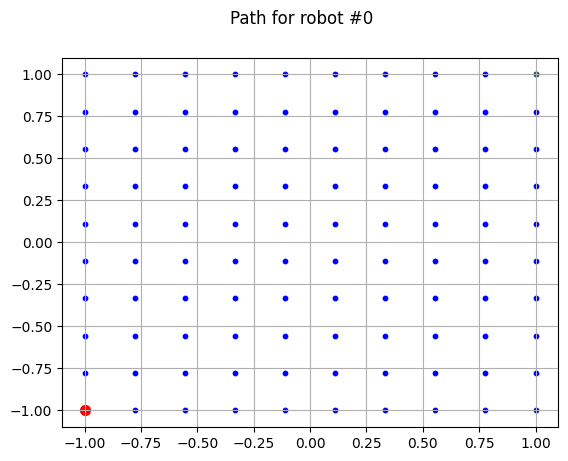

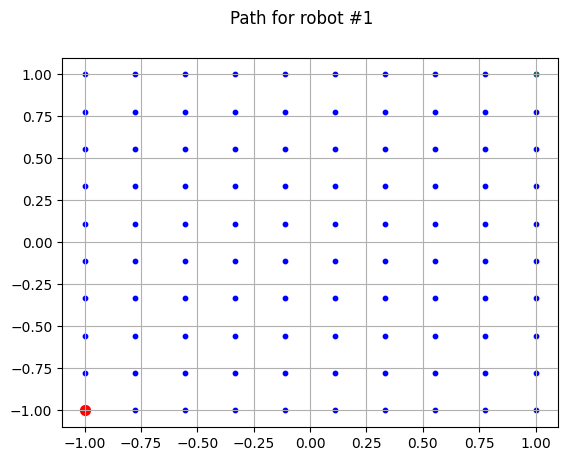

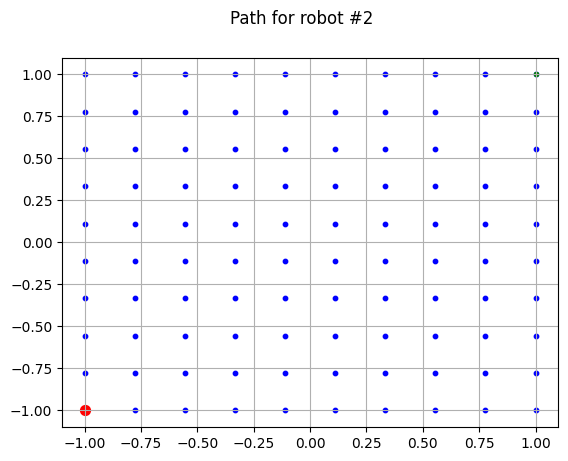

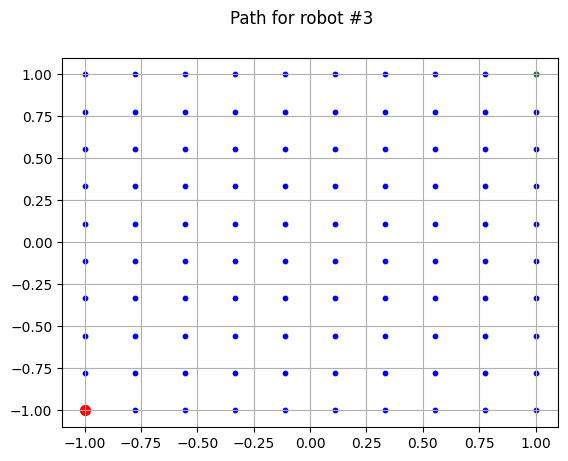

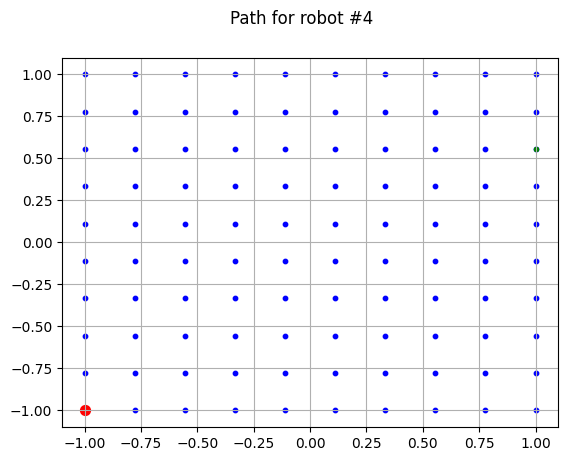

In [81]:
# Graphical sanity check for the tour
for ki, tour in enumerate(shortest_tours):
    fig = plt.figure()
    fig.suptitle(f"Path for robot #{ki}")
    plt.scatter(nodes[0, :, :, 0], nodes[0, :, :, 1], c='blue', s=10)
    plt.scatter(nodes[0, depots_i[:, 0], depots_i[:, 1], 0], nodes[0, depots_i[:, 0], depots_i[:, 1], 1], c='red', s=50)
    tour_np = np.array([]).reshape(0, 2)
    for i, j in tour:
        plt.scatter(nodes[0, i, j, 0], nodes[0, i, j, 1], c="green", s=8)
        tour_np = np.concatenate((tour_np, nodes[0, i, j].reshape(1, 2)))
    plt.plot(tour_np[:, 0], tour_np[:, 1], color="green", linewidth=1)
    plt.grid()
    plt.show()
